In [1]:
import rmcalyse
from rmcalyse import rmc_data
from plugins.distance_calculations import distance_calculator



 8888888b. 888b     d888 .d8888b.         888                        
 888   Y88b8888b   d8888d88P  Y88b        888                        
 888    88888888b.d88888888    888        888                        
 888   d88P888Y88888P888888        8888b. 888888  888.d8888b  .d88b. 
 8888888P" 888 Y888P 888888           "88b888888  88888K     d8P  Y8b
 888 T88b  888  Y8P  888888    888.d888888888888  888"Y8888b.88888888
 888  T88b 888   "   888Y88b  d88P888  888888Y88b 888     X88Y8b.    
 888   T88b888       888 "Y8888P" "Y888888888 "Y88888 88888P' "Y8888 
                                                   888               
                                              Y8b d88P               
                                               "Y88P"                
 ------------- A toolbox for analysing RMCProfile outputs -----------
 --------------------------------------------------------------------
 ------------------------ Anton Goetzee-Barral ----------------------
 -----------------

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
# test distance calc import is working 

a = np.array([0,0,0])
b = np.array([3,4,12])
distance_calculator.eucledian_distance(a,b) == 13

True

In [4]:
position_labels = rmc_data.position_labels
orthonormal_positions = rmc_data.orthonormal_positions
position_labels[:10],orthonormal_positions[:10]

(array([['1', 'Pb'],
        ['2', 'Pb'],
        ['3', 'Pb'],
        ['4', 'Pb'],
        ['5', 'Pb'],
        ['6', 'Pb'],
        ['7', 'Pb'],
        ['8', 'Pb'],
        ['9', 'Pb'],
        ['10', 'Pb']], dtype='<U17'),
 array([[28.01612458,  7.32741379, 13.74853319],
        [20.19724864,  4.33931455,  4.49945487],
        [15.25576196, 12.41764315, 31.36626833],
        [ 4.40477919, 31.43810017, 20.42902155],
        [-5.47502782, 37.78394345, 27.19030863],
        [ 7.19968395, 20.73505752, 22.78071159],
        [10.74803317,  4.14763275, 18.21494805],
        [36.34097868, 31.79120755,  2.27578268],
        [ 7.40798107, 15.54708618, 22.59397626],
        [18.91495525,  1.1898463 ,  6.8266021 ]]))

In [5]:
center_atom = ['O']
orbit_atom = ['Ti']
max_d = 4 # max distance for centroid polyhedra
coordination_no = 8

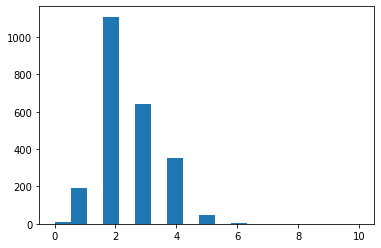

In [6]:
center_atom_labels = []
center_atom_positions = []

orbit_atom_labels = []
orbit_atom_positions = []

for center_label, center_position in zip(position_labels, orthonormal_positions):
    if center_atom in center_label:
        polyhedra_labels = []
        polyhedra_positions = []
        polyhedra_labels.append(center_label[1])
        polyhedra_positions.append(center_position)
        for orbit_label, orbit_position in zip(position_labels, orthonormal_positions):
            if orbit_atom in orbit_label and distance_calculator.eucledian_distance(center_position, orbit_position) < max_d:
                polyhedra_labels.append(orbit_label[1])
                polyhedra_positions.append(orbit_position)
        
        
        center_atom_labels.append(polyhedra_labels[0])
        center_atom_positions.append(polyhedra_positions[0])
        
        orbit_atom_labels.append(polyhedra_labels[1:])
        orbit_atom_positions.append(polyhedra_positions[1:])

lengths = []
for i in orbit_atom_labels:
    lengths.append(len(i))
    
bins = np.linspace(0,10,20)
plt.hist(lengths, bins =bins)
plt.show()

In [11]:
# orthonormal_positions = np.array([[0, 0, 0], [0, 0, 0.75], [0, 0.75, 0.75], [0.75, 0.75, 0.75]]) # testing
# position_labels = np.array([['1', 'A'], ['2', 'A'], ['3', 'A'], ['4', 'A']]) # testing
# center_atom = ['A'] # testing

def array_distance(positions_labels, orthonormal_positions):

    positions = np.array([x for x in orthonormal_positions]) # want a numpy array of the positions
    offset = rmc_data.cell_parameters[0]/2 # half a unit cell (helpfully it's cubic so don't need anything more complex than this)
    positions -= offset # now the unit cell goes from -19 to 19
    idx_of_interest = [i for i,x in enumerate(orthonormal_positions) if position_labels[i][1] in center_atom] # hack to find a list of indices we're interested in
    results = np.zeros((positions.shape[0],3)) # predefine results array for speed
    all_distances = []

    t0 = time.perf_counter()
    for i in idx_of_interest:
        shifted = (positions - positions[i]) #shift all atoms so this one is at the origin
        reshuffled = np.mod(shifted+offset, offset*2)-offset # the clever moving of atoms outside -19:19 back
        distances  = np.power(np.square(reshuffled).sum(1),0.5) # calculate distances
        idx = np.argsort(distances) # returns an array of sorted indices (i.e. distances[idx[0]] = 0, the distance from the atom to itself, distances[idx[1]] is somewthing like 2.5, etc.
        results[i,:] = -np.mean(reshuffled[idx[1:7], :],0) #note we start at 1 to avoid the 0 for the same atom. Then average them. this calculates the central point so the displacements vector is -ve this
        all_distances.append(distances)
    runtime = round(time.perf_counter() - t0, 5)
    print(f'total time taken {runtime} s')
    return distances
    

distances_no = array_distance(position_labels, orthonormal_positions)

total time taken 1.52333 s


In [12]:
distances_no[:5]

array([25.61700929, 17.26216055, 13.55755667, 12.59896746, 14.97663746])

In [13]:
def array_distance_orthonormaliser(position_labels, raw_positions):
    
    positions = np.array([x for x in raw_positions]) # want a numpy array of the positions
    
    offset = 0.5 # half a unit cell (helpfully it's cubic so don't need anything more complex than this)
    
    positions -= offset # now the unit cell goes from -19 to 19
    
    idx_of_interest = [i for i,x in enumerate(raw_positions) if position_labels[i][1] in center_atom] # hack to find a list of indices we're interested in
    
    results = np.zeros((positions.shape[0],3)) # predefine results array for speed
    all_distances = []

    t0 = time.perf_counter()
    
    for i in idx_of_interest:
        
        shifted = (positions - positions[i]) #shift all atoms so this one is at the origin
        
        reshuffled = np.mod(shifted + offset, offset * 2) - offset # the clever moving of atoms outside -19:19 back
        
        reshuffled = np.dot(rmc_data.matrix, reshuffled.T).T
        
        distances  = np.power(np.square(reshuffled).sum(1),0.5) # calculate distances
        
        idx = np.argsort(distances) # returns an array of sorted indices (i.e. distances[idx[0]] = 0, the distance from the atom to itself, distances[idx[1]] is somewthing like 2.5, etc.
        
        results[i,:] = -np.mean(reshuffled[idx[1:7], :],0) #note we start at 1 to avoid the 0 for the same atom. Then average them. this calculates the central point so the displacements vector is -ve this
        
        all_distances.append(distances)
    runtime = round(time.perf_counter() - t0, 5)
    print(f'total time taken {runtime} s')
    return distances

distances_yo = array_distance_orthonormaliser(position_labels, rmc_data.raw_basis_positions)

total time taken 1.57925 s


In [14]:
distances_yo[:5]

array([18.05270943, 14.39442607, 14.17455117, 12.59896746, 14.97663746])

In [15]:
print(len(distances_yo), len(distances_no))

3920 3920
